# X-Ray Location

This notebook is an example of using a pre-trained network (in this case the "inceptionv3" network), changing it slightly, and then continue training on a different task. Specifically, our goal is to give the network pictures of x-rays of abdomens or chests, and have the network recognize those categories.

This notebook is based on https://github.com/paras42/Hello_World_Deep_Learning/blob/master/HelloWorldDeepLearning.ipynb

## Setup

First, we import the conx library:

In [1]:
import conx as cx

Using TensorFlow backend.
Conx, version 3.6.10


We download the zip file that contains the training, validation, and testing data:

In [2]:
cx.download("https://github.com/paras42/Hello_World_Deep_Learning/blob/master/Open_I_abd_vs_CXRs.zip?raw=true")

Using cached https://github.com/paras42/Hello_World_Deep_Learning/blob/master/Open_I_abd_vs_CXRs.zip?raw=true as './Open_I_abd_vs_CXRs.zip'.
Unzipping files...
Done!
Items available from downloaded zip file:
     ./Open_I_abd_vs_CXRs/
     ./Open_I_abd_vs_CXRs/TEST/
     ./Open_I_abd_vs_CXRs/TEST/abd2.png
     ./Open_I_abd_vs_CXRs/TEST/chest2.png
     ./Open_I_abd_vs_CXRs/VAL/
     ./Open_I_abd_vs_CXRs/TRAIN/
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/PMC2584007_1752-1947-2-335-2.png
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/PMC2584007_1752-1947-2-335-2 (1).png
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_22.png
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_21.png
     ./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/openI_20.png
     ./Open_I_abd_vs_CXRs/VAL/openI_CXR/
     ./Open_I_abd_vs_CXRs/VAL/openI_CXR/20_IM-0653-1001.png
     ./Open_I_abd_vs_CXRs/VAL/openI_CXR/17_IM-0460-2001_invert.png
     ./Open_I_abd_vs_CXRs/VAL/openI_CXR

Next, we examine the training and validation pictures:

In [3]:
import glob

In [4]:
abdomen_images = glob.glob("./Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/*.png")
train_abdomen_count = len(abdomen_images)
print("Number of training abdomen images:", train_abdomen_count)
abdomen_images.extend(glob.glob("./Open_I_abd_vs_CXRs/VAL/openI_abd_xray/*.png"))
print("Number of validation abdomen images:", len(abdomen_images))

Number of training abdomen images: 32
Number of validation abdomen images: 37


Let's take a look at one of these pictures, resizing it to the same size that we will use in the network:

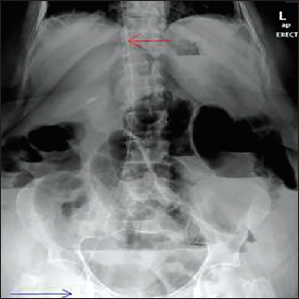

In [5]:
cx.image(abdomen_images[0], resize=(299,299))

And we do the same for the chest images:

In [6]:
chest_images = glob.glob("./Open_I_abd_vs_CXRs/TRAIN/openI_CXR/*.png")
train_chest_count = len(chest_images)
print("Number of training chest images:", train_chest_count)
chest_images.extend(glob.glob("./Open_I_abd_vs_CXRs/VAL/openI_CXR/*.png"))
print("Number of validation chest images:", len(chest_images))

Number of training chest images: 33
Number of validation chest images: 38


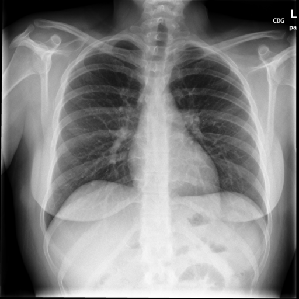

In [7]:
cx.image(chest_images[0], resize=(299,299))

## The Network

For this example, we use the InceptionV3 network with pre-trained weights. This may take a few minutes to load:

In [8]:
base_net = cx.Network.get("inceptionv3")

In [9]:
base_net.info()

**Network**: InceptionV3

   * **Status**: compiled 
   * **Layers**: 313 

This network architecture comes from the paper:

Rethinking the Inception Architecture for Computer Vision

The default input size for this model is 299 x 299.

These weights are released under the [Apache License](https://github.com/tensorflow/models/blob/master/LICENSE).

Sources:

   * http://arxiv.org/abs/1512.00567



In [10]:
base_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
len(base_net.layers)

313

This is a fairly deep network with 314 layers. It has almost 24 million trainable weights.

We are going to use these weights, but we wish to have a different task. The original task was to map a picture to one of 1,000 categories. In our x-ray case, we only have two cases. So, we will remove the last two layers, and replace them.

We remove the last layer:

In [12]:
base_net.delete_layer("predictions")

We remove the new last layer:

In [13]:
base_net.delete_layer("avg_pool")

Now, we will build a new network to replace the final two layers. Note that we make sure that we use different names than are in the InceptionV3 network:

In [14]:
top_net = cx.Network("Top")
top_net.add(cx.Layer("inputs", (8,8,2048)),
            cx.GlobalAveragePooling2DLayer("avg_pool2"),
            cx.Layer("hidden-last", 256, dropout=.5, activation="relu"),
            cx.Layer("output", 2, activation="softmax"))
top_net.connect()

In [15]:
top_net.compile(optimizer="adam", lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                error="categorical_crossentropy")

And finally, we connect the base_net to the new top_net starting with "mixed10" and connecting it to the second layer of the top_net:

In [16]:
base_net.connect_network("mixed10", top_net)

The new network looks similar to the original:

In [17]:
base_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## The Dataset

Next, we create training/validation data in the form [inputs, targets] where:

* [1,0] - represents abdomen
* [0,1] - represents chest

Note that we put the training data first, followed validation data:

In [18]:
data = []
for filename in abdomen_images[:train_abdomen_count]:
    data.append([base_net.preprocess(cx.image_to_array(cx.image(filename), 
                                                       resize=(299,299))), [1, 0]])
for filename in chest_images[:train_chest_count]:
    data.append([base_net.preprocess(cx.image_to_array(cx.image(filename), 
                                                       resize=(299,299))), [0, 1]])
for filename in abdomen_images[train_abdomen_count:]:
    data.append([base_net.preprocess(cx.image_to_array(cx.image(filename), 
                                                       resize=(299,299))), [1, 0]])
for filename in chest_images[train_chest_count:]:
    data.append([base_net.preprocess(cx.image_to_array(cx.image(filename), 
                                                       resize=(299,299))), [0, 1]])

Next, we turn the data into a conx.Dataset:

In [19]:
dataset = cx.Dataset()
dataset.load(data)

We split the data into training/validation sets:

In [20]:
dataset.split(len(data) - (train_abdomen_count + train_chest_count))

In [21]:
dataset.summary()

_________________________________________________________________
Unnamed Dataset:
Patterns    Shape                 Range                         
inputs      (299, 299, 3)         (-1.0, 1.0)                   
targets     (2,)                  (0.0, 1.0)                    
Total patterns: 75
   Training patterns: 65
   Testing patterns: 10
_________________________________________________________________


Let's see what the training data looks like:

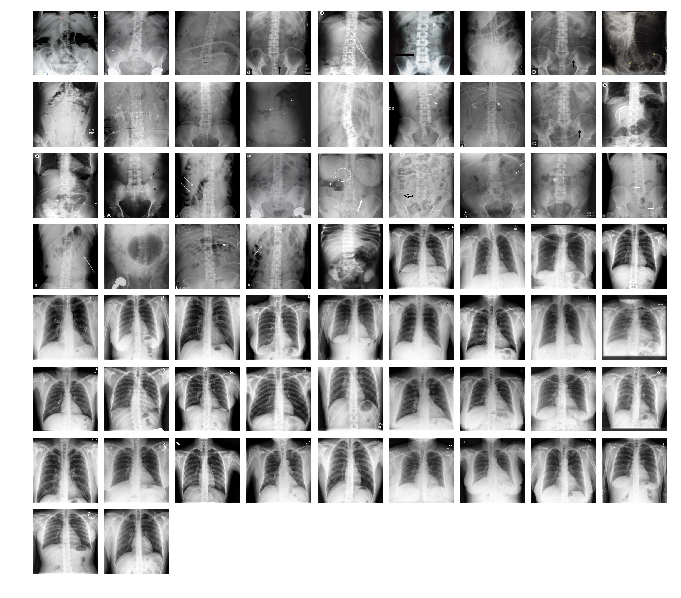

In [64]:
cx.view([cx.array_to_image(v) for v in dataset.train_inputs])

And let's see what the test data looks like:

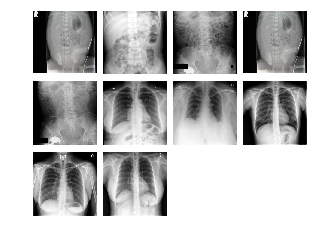

In [65]:
cx.view([cx.array_to_image(v) for v in dataset.test_inputs])

# Training

We set the network's dataset to be the dataset we created above:

In [22]:
base_net.set_dataset(dataset)

And do a test propagate to make sure the network is functional:

In [23]:
base_net.propagate(base_net.preprocess(base_net.dataset.inputs[0]))

[0.5009004473686218, 0.4990994930267334]

The network has no idea what these images are, and produces a [.5, .5] output (50/50 guess).

And now we are ready to train:

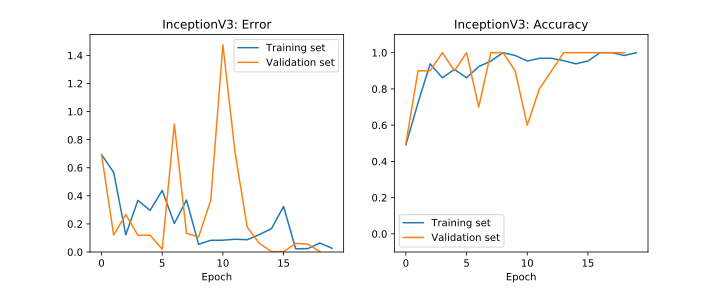

Interrupted! Cleaning up...
       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#   19 |   0.02615 |   1.00000 


KeyboardInterrupt: 

In [32]:
base_net.train(20, batch_size=5)

## Testing

Let's test an input, #10:

In [66]:
base_net.propagate(base_net.dataset.inputs[10])

[0.999460756778717, 0.000539280183147639]

Is this correct? Let's look at the target for #10:

In [67]:
base_net.dataset.targets[10]

[1.0, 0.0]

Now, let's see which it gets wrong of the entire training set:

In [46]:
base_net.dataset.inputs.select(lambda i, ds: cx.argmax(base_net.propagate(ds.inputs[i])) != cx.argmax(ds.targets[i]), 
                               index=True)

[]

Which of the entire test set does it get wrong?

In [51]:
base_net.dataset.test_inputs.select(lambda i, ds: cx.argmax(base_net.propagate(ds.test_inputs[i])) != cx.argmax(ds.test_targets[i]), 
                               index=True)

[]

It got everything correct!